# CNNによる画像認識（CIFAR10, PyTorch実装）


---
## 目的
CIFAR10 Datasetを用いて10クラスの物体認識を行う．プログラムの構成は，MNISTによる文字認識のプログラムと同様になっているため，基礎的な説明はそちらを参照して頂きたい．このページでは，MNISTによる文字認識のプログラムとの差分について書いていく．

GPUを用いたネットワークの計算を行う．


## 準備

### Google Colaboratoryの設定確認・変更
本チュートリアルではPyTorchを利用してニューラルネットワークの実装を確認，学習および評価を行います．
**GPUを用いて処理を行うために，上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください．**


## 使用するデータセット

### データセット
今回の物体認識では，CIFAR10データセットを用いる．CIFAR10データセットは，飛行機や犬などの10クラスの物体が表示されている画像から構成されたデータセットである．

![CIFAR10_sample.png](https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/176458/b6b43478-c85f-9211-7bc6-227d9b387af5.png)

## モジュールのインポート
はじめに必要なモジュールをインポートする．

### GPUの確認
GPUを使用した計算が可能かどうかを確認します．

`Use CUDA: True`と表示されれば，GPUを使用した計算をPyTorchで行うことが可能です．
Falseとなっている場合は，上記の「Google Colaboratoryの設定確認・変更」に記載している手順にしたがって，設定を変更した後に，モジュールのインポートから始めてください．


In [ ]:
# モジュールのインポート
from time import time
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

import torchsummary

# GPUの確認
use_cuda = torch.cuda.is_available()
print('Use CUDA:', use_cuda)

Use CUDA: True


## データセットの読み込みと確認
学習データ（CIFAR10データセット）を読み込みます．

読み込んだ学習データのサイズを確認します．
学習データは5万枚，1つのデータサイズは3x32x32の画像のような形式となっています．
これは32x32ピクセルのカラー画像という意味になります．

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
])

train_data = torchvision.datasets.CIFAR10(root="./", train=True, transform=transform, download=True)
test_data = torchvision.datasets.CIFAR10(root="./", train=False, transform=transform, download=True)

print(train_data)
print(test_data)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomHorizontalFlip(p=0.5)
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomHorizontalFlip(p=0.5)
           )


### CIFAR10データセットの表示
CIFAR10データセットに含まれる画像を表示してみます．
ここでは，matplotlibを用いて複数の画像を表示させるプログラムを利用します．

<Figure size 432x288 with 0 Axes>

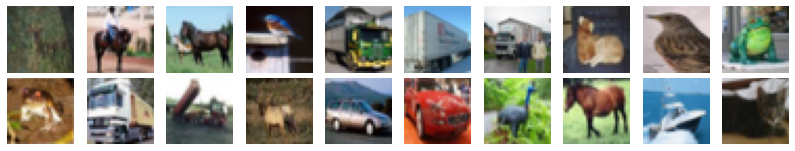

In [ ]:
import matplotlib.pyplot as plt

cols = 10
rows = 2

plt.clf()
fig = plt.figure(figsize=(14, 4.8))
for r in range(rows):
    for c in range(cols):
        ax = fig.add_subplot(r+1, cols, c+1)
        ax.imshow(train_data[c+r*cols][0].permute(1, 2, 0))
        ax.set_axis_off()
plt.show()

## ネットワークモデルの定義

畳み込みニューラルネットワークを定義します．

ここでは，畳み込み層２層，全結合層３層から構成されるネットワークとします．

1層目の畳み込み層は入力チャンネル数が3，出力する特徴マップ数が16，畳み込むフィルタサイズが3x3です．
2層目の畳み込み層は入力チャネル数が16．出力する特徴マップ数が32，畳み込むフィルタサイズは同じく3x3です．
１つ目の全結合層は入力ユニット数は`8*8*32`とし，出力は1024としています．
次の全結合層入力，出力共に1024，出力層は入力が1024，出力が10です．
また，活性化関数として`self.act`にシグモイド関数を定義します．
さらに，プーリング処理を行うための`self.pool`を定義します．
ここでは，maxpoolingを使用します．
これらの各層の構成を`__init__`関数で定義します．

次に，`forward`関数では，定義した層を接続して処理するように記述します．
`forward`関数の引数`x`は入力データです．
それを`__init__`関数で定義した`conv1`に入力し，その出力を活性化関数である`self.act`に与えます．
そして，その出力を`self.pool`に与えて，プーリング処理結果を`h`として出力します．
2層目の畳み込み層でも同様の手順で処理を行います．

畳み込みを適用した後の特徴マップを全結合層へと入力して，識別結果を出力します．
まず．畳み込みによって得られた特徴マップの形状（チャンネルx縦x横）を1次元の配列へと変換します．
ここで，`view()`を用いることで，`h`の配列を操作します．引数として，変換したい配列のサイズを入力します．
まず一つ目の引数の`h.size()[0]`で，`h`の1次元目のサイズを取得し，変換後の配列の1次元目のサイズとして指定します．
二つ目の引数の`-1`で任意のサイズを指定します．
これにより，`h`を（バッチ数x任意の長さのデータ）の形状へ変換します．
変換した`h`を全結合層および活性化関数へと順次入力することで，最終的にクラススコアを返します．

## ★ネットワーク構造の変更
畳み込み層，プーリング層の層数を増やし，また特徴マップ数も増やした．

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.l1 = nn.Linear(2 * 2 * 128, 1024)
        self.l2 = nn.Linear(1024, 1024)
        self.l3 = nn.Linear(1024, 10)
        self.act = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        h = self.act(self.conv1(x))
        h = self.pool(h)

        h = self.act(self.conv2(h))
        h = self.pool(h)

        h = self.act(self.conv3(h))
        h = self.pool(h)

        h = self.act(self.conv4(h))
        h = self.pool(h)

        h = h.view(h.size()[0], -1)
        h = self.act(self.l1(h))
        h = self.act(self.l2(h))
        h = self.l3(h)
        return h

## ネットワークの作成
上のプログラムで定義したネットワークを作成します．

`CNN`クラスを呼び出して，ネットワークモデルを定義します．
また，GPUを使う場合（`use_cuda == True`）には，ネットワークモデルをGPUメモリ上に配置します．
これにより，GPUを用いた演算が可能となります．

学習を行う際の最適化方法としてモーメンタムSGD(モーメンタム付き確率的勾配降下法）を利用します．
また，学習率を0.01，モーメンタムを0.9として引数に与えます．

In [ ]:
model = CNN()
if use_cuda:
    model.cuda()

# ★学習率を0.005に変更
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

# モデルの情報を表示
torchsummary.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
              ReLU-5          [-1, 128, 16, 16]               0
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
              ReLU-8            [-1, 256, 8, 8]               0
         MaxPool2d-9            [-1, 256, 4, 4]               0
           Conv2d-10            [-1, 128, 4, 4]         295,040
             ReLU-11            [-1, 128, 4, 4]               0
        MaxPool2d-12            [-1, 128, 2, 2]               0
           Linear-13                 [-1, 1024]         525,312
             ReLU-14                 [-

## 学習
読み込んだCIFARデータセットと作成したネットワークを用いて，学習を行います．

1回の誤差を算出するデータ数（ミニバッチサイズ）を64，学習エポック数を10とします．

次にデータローダーを定義します．
データローダーでは，上で読み込んだデータセット（`train_data`）を用いて，for文で指定したミニバッチサイズでデータを読み込むオブジェクトを作成します．
この時，`shuffle=True`と設定することで，読み込むデータを毎回ランダムに指定します．

次に，誤差関数を設定します．
今回は，分類問題をあつかうため，クロスエントロピー誤差を計算するための`CrossEntropyLoss`を`criterion`として定義します．

学習を開始します．

各更新において，学習用データと教師データをそれぞれ`image`と`label`とします．
学習モデルにimageを与えて各クラスの確率yを取得します．
各クラスの確率yと教師ラベルtとの誤差を`criterion`で算出します．
また，認識精度も算出します．
そして，誤差をbackward関数で逆伝播し，ネットワークの更新を行います．

In [ ]:
# ミニバッチサイズ・エポック数の設定
batch_size = 256
epoch_num = 50
n_iter = len(train_data) / batch_size

# データローダーの設定
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# 誤差関数の設定
criterion = nn.CrossEntropyLoss()
if use_cuda:
    criterion.cuda()

# ネットワークを学習モードへ変更
model.train()

start = time()
for epoch in range(1, epoch_num+1):
    sum_loss = 0.0
    count = 0
    
    for image, label in train_loader:
        
        if use_cuda:
            image = image.cuda()
            label = label.cuda()
            
        y = model(image)
        
        loss = criterion(y, label)
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        sum_loss += loss.item()
        
        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)
        
    print("epoch: {}, mean loss: {}, mean accuracy: {}, elapsed_time :{}".format(epoch,
                                                                                 sum_loss / n_iter,
                                                                                 count.item() / len(train_data),
                                                                                 time() - start))

epoch: 1, mean loss: 2.310270485839844, mean accuracy: 0.1055, elapsed_time :19.0005521774292
epoch: 2, mean loss: 2.3084074963378907, mean accuracy: 0.1206, elapsed_time :34.424153327941895
epoch: 3, mean loss: 2.2953308239746093, mean accuracy: 0.15044, elapsed_time :49.86058259010315
epoch: 4, mean loss: 2.1160013024902344, mean accuracy: 0.21338, elapsed_time :65.08706641197205
epoch: 5, mean loss: 1.9864085144042969, mean accuracy: 0.26426, elapsed_time :80.84979248046875
epoch: 6, mean loss: 1.8963659075927735, mean accuracy: 0.3004, elapsed_time :96.59392428398132
epoch: 7, mean loss: 1.7598471044921875, mean accuracy: 0.35318, elapsed_time :111.78148460388184
epoch: 8, mean loss: 1.6313215435791015, mean accuracy: 0.40038, elapsed_time :126.80630040168762
epoch: 9, mean loss: 1.5451702276611328, mean accuracy: 0.43226, elapsed_time :142.0278594493866
epoch: 10, mean loss: 1.4645685272216797, mean accuracy: 0.46326, elapsed_time :157.58820223808289
epoch: 11, mean loss: 1.394913

## テスト
学習したネットワークモデルを用いて評価を行います．

In [ ]:
# データローダーの準備
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)

# ネットワークを評価モードへ変更
model.eval()

# 評価の実行
count = 0
with torch.no_grad():
    for image, label in test_loader:

        if use_cuda:
            image = image.cuda()
            label = label.cuda()
            
        y = model(image)

        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)

print("test accuracy: {}".format(count.item() / 10000.))

test accuracy: 0.7665


## 課題

### 1. ネットワークの構造を変更し，認識精度の変化を確認しましょう．

**ヒント：ネットワーク構造の変更としては，次のようなものが考えられます．**
* 中間層のユニット数，畳み込みのカーネルサイズ
* 層の数
* 活性化関数
  * `nn.Tanh()`や`nn.ReLU()`, `nn.LeakyReLU()`などが考えられます．
  * その他のPyTorchで使用できる活性化関数は[こちらページ](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)にまとめられています．


### 2. 学習の設定を変更し，認識精度の変化を確認しましょう．

**ヒント：プログラムの中で変更で切る設定は次のようなものが存在します．**
* ミニバッチサイズ
* 学習回数（Epoch数）
* 学習率
* 最適化手法
  * `torch.optim.Adagrad()`や`torch.optim.Adam()`などが考えられます．
  * PyTorchで使用できる最適化手法は[こちらのページ](https://pytorch.org/docs/stable/optim.html#algorithms)にまとめられています．
